<a href="https://colab.research.google.com/github/mrScissors/spookyAuthors/blob/master/spookyAuthors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
zip = '/content/gdrive/My Drive/spooky-author-identification.zip'

import zipfile

with zipfile.ZipFile(zip,"r") as z:
  z.extractall(".")

In [3]:
with zipfile.ZipFile('train.zip',"r") as z:
  z.extractall(".")

with zipfile.ZipFile('test.zip',"r") as z:
  z.extractall(".")

In [27]:
! ls

gdrive	     sample_submission.csv  test.csv  train.csv
sample_data  sample_submission.zip  test.zip  train.zip


# Importing stuff and downloading libs data, reading data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('popular')
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
ps =PorterStemmer()

from spacy.lang.en import English
nlp = English()
from spacy.lang.en.stop_words import STOP_WORDS
! python -m spacy download en

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import feature_selection, feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [30]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [31]:
train.shape

(19579, 3)

# Preprocessing function

In [32]:
# choose 'nltk or 'spacy' for stopword method, lemma = True for lemmatization, stemming is True by default
def preprocessText(text, library, lemma = False, stemm = True):

  text = text.lower()

  # removing punctuation
  text = re.sub(r'[^\w\s]','',text)
  
  # removing numeric characters
  text = re.sub('\d', '', text)

  words = text.split()

  # Lemmatizing
  if (lemma and library == 'spacy'):
    words = []
    doc = nlp(text)
    for token in doc:
      words.append(token.lemma_)

  if (lemma and library == 'nltk'):
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]

  # remove stop words using NLTK
  if (library == 'nltk'):
    words = [i for i in words if not i in stop_words]

  # remove stop words using SpaCy
  if (library == 'spacy'):
    doc = nlp(' '.join([word for word in words]))
    words = []
    for token in doc:
      lexeme = nlp.vocab[token.text]
      if lexeme.is_stop == False:
        words.append(token.text)

  # Stemming
  if (stemm):
    words = [ps.stem(word) for word in words]


  if (len(words) == 0):
    return text
  else:
    return ' '.join([word for word in words])

In [33]:
train['cleanedText'] = train['text'].apply(lambda x: preprocessText(x, library = 'spacy', lemma = True))
train.head()

,id,text,author,cleanedText
0,id26305,"This process, however, afforded me no means of...",EAP,process afford mean ascertain dimens dungeon c...
1,id17569,It never once occurred to me that the fumbling...,HPL,occur fumbl mere mistak
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box caper hill cut manner...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,love spring look windsor terrac sixteen fertil...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,find gold superintend abandon attempt perplex ...


In [34]:
test['cleanedText'] = test['text'].apply(lambda x: preprocessText(x, library = 'spacy', lemma = True))
test.head()

,id,text,cleanedText
0,id02310,"Still, as I urged our leaving Ireland with suc...",urg leav ireland inquietud impati father thoug...
1,id24541,"If a fire wanted fanning, it could readily be ...",fire want fan readili fan newspap govern grew ...
2,id00134,And when they had broken down the frail door t...,broken frail door found cleanli pick human ske...
3,id27757,While I was thinking how I should possibly man...,think possibl manag actual tumbl head roll ste...
4,id04081,I am not sure to what limit his knowledge may ...,sure limit knowledg extend


In [35]:
X_train = train['cleanedText']
y_train =  train['author']

# Using tfidf for classification

In [36]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfTrain = tfIdfVectorizer.fit_transform(X_train.tolist())

In [37]:
tfTrain.shape

(19579, 15469)

feature selection using chi2

In [38]:
X_names = tfIdfVectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2, p = feature_selection.chi2(tfTrain, y_train==cat)
    # print (len(1-p))
    # break
    dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [39]:
print(len(X_names))

1954


dimensionality reducued from 15469 to 1954

In [40]:
tfIdfVectorizer=TfidfVectorizer(vocabulary=X_names)
tfTrain = tfIdfVectorizer.fit_transform(X_train.tolist())

In [41]:
tfTrain.shape

(19579, 1954)

In [42]:
model = RandomForestClassifier(n_estimators=600)
model.fit(tfTrain, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
yPred = model.predict(tfTrain)
print(accuracy_score(y_train, yPred))
print(classification_report(y_train, yPred))

0.9696102967465141
              precision    recall  f1-score   support

         EAP       0.95      0.99      0.97      7900
         HPL       0.99      0.96      0.98      5635
         MWS       0.98      0.96      0.97      6044

    accuracy                           0.97     19579
   macro avg       0.97      0.97      0.97     19579
weighted avg       0.97      0.97      0.97     19579



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

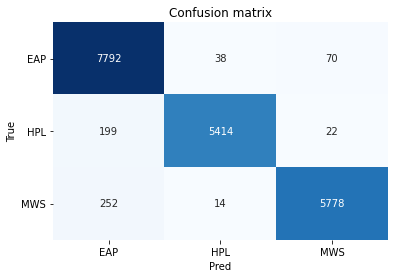

In [44]:
## Plot confusion matrix
classes = np.unique(y_train)
cm = confusion_matrix(y_train, yPred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [45]:
tfTestSubmit = tfIdfVectorizer.transform(test['text'].tolist())
tfTestSubmit.shape

(8392, 1954)

In [46]:
with zipfile.ZipFile('sample_submission.zip',"r") as z:
  z.extractall(".")

In [47]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [48]:
model.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [49]:
submitDf = pd.DataFrame(model.predict_proba(tfTestSubmit))
submitDf['id'] = test['id']
submitDf.head()

,0,1,2,id
0,0.180050,0.091667,0.728283,id02310
1,0.942500,0.033333,0.024167,id24541
2,0.295108,0.692483,0.012409,id00134
3,0.318075,0.288424,0.393500,id27757
4,0.672460,0.269207,0.058333,id04081


In [50]:
submitDf.rename({0: 'EAP', 1: 'HPL', 2: 'MWS'}, axis=1, inplace=True)
submitDf.head()

,EAP,HPL,MWS,id
0,0.180050,0.091667,0.728283,id02310
1,0.942500,0.033333,0.024167,id24541
2,0.295108,0.692483,0.012409,id00134
3,0.318075,0.288424,0.393500,id27757
4,0.672460,0.269207,0.058333,id04081


In [51]:
submitDf = submitDf[['id', 'EAP', 'HPL', 'MWS']]
submitDf.head()

,id,EAP,HPL,MWS
0,id02310,0.180050,0.091667,0.728283
1,id24541,0.942500,0.033333,0.024167
2,id00134,0.295108,0.692483,0.012409
3,id27757,0.318075,0.288424,0.393500
4,id04081,0.672460,0.269207,0.058333


In [52]:
submitDf.to_csv('submission.csv',index=False)

# Using doc2vec for classification

In [53]:
tagged_data = [TaggedDocument(words=word_tokenize(_d),
                              tags=[str(i)]) for i, _d in enumerate(train['cleanedText'])]

In [54]:
model = Doc2Vec(min_count=10)
  
model.build_vocab(tagged_data)

model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=5)


In [55]:
docVectors = []
for i in train.cleanedText.to_list():
  docVectors.append(model.infer_vector(word_tokenize(i)))

In [56]:
len(docVectors)

19579

In [57]:
randomForest = RandomForestClassifier(n_estimators=600)
randomForest.fit(docVectors, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

1.0
              precision    recall  f1-score   support

         EAP       1.00      1.00      1.00      7900
         HPL       1.00      1.00      1.00      5635
         MWS       1.00      1.00      1.00      6044

    accuracy                           1.00     19579
   macro avg       1.00      1.00      1.00     19579
weighted avg       1.00      1.00      1.00     19579



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

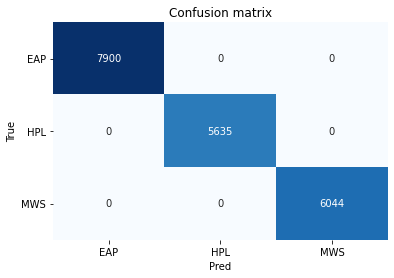

In [58]:
yPred = randomForest.predict(docVectors)
print(accuracy_score(y_train, yPred))
print(classification_report(y_train, yPred))

## Plot confusion matrix
classes = np.unique(y_train)
cm = confusion_matrix(y_train, yPred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [59]:
docVectorsTest = []
for i in test.cleanedText.to_list():
  docVectorsTest.append(model.infer_vector(word_tokenize(i)))

In [60]:
randomForest.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [61]:
submitDf = pd.DataFrame(randomForest.predict_proba(docVectorsTest))
submitDf['id'] = test['id']
submitDf.head()

,0,1,2,id
0,0.350000,0.248333,0.401667,id02310
1,0.396667,0.230000,0.373333,id24541
2,0.371667,0.333333,0.295000,id00134
3,0.401667,0.341667,0.256667,id27757
4,0.395000,0.288333,0.316667,id04081


In [62]:
submitDf.rename({0: 'EAP', 1: 'HPL', 2: 'MWS'}, axis=1, inplace=True)
submitDf.head()

,EAP,HPL,MWS,id
0,0.350000,0.248333,0.401667,id02310
1,0.396667,0.230000,0.373333,id24541
2,0.371667,0.333333,0.295000,id00134
3,0.401667,0.341667,0.256667,id27757
4,0.395000,0.288333,0.316667,id04081


In [63]:
submitDf = submitDf[['id', 'EAP', 'HPL', 'MWS']]
submitDf.head()

,id,EAP,HPL,MWS
0,id02310,0.350000,0.248333,0.401667
1,id24541,0.396667,0.230000,0.373333
2,id00134,0.371667,0.333333,0.295000
3,id27757,0.401667,0.341667,0.256667
4,id04081,0.395000,0.288333,0.316667


In [64]:
submitDf.to_csv('submission.csv',index=False)